In [1]:
import configparser
import v20

config = configparser.ConfigParser()
config.read('config.ini')

API_KEY = config['OANDA2']['API_KEY'] 
ACCOUNT_ID = config['OANDA2']['ACCOUNT_ID']
host_practice   = "api-fxpractice.oanda.com"
key = f'Bearer {API_KEY}'

# contexts
ctx = v20.Context(hostname=host_practice, token=key)
ctx.set_header(key='Authorization', value=key)

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Hi-Low search by sectioning

In [88]:
def get_candles(inst, count=15, tf='M5'):
    params = dict(price='M', granularity=tf, count=count)
    candles = ctx.instrument.candles(inst, **params).get('candles')
    return pd.DataFrame.from_dict(get_rows(candles))

def get_rows(candles):
    for c in candles:
        c = c.dict()
        row = {}
        row['complete'] = c['complete']
        #row['time'] = pd.to_datetime(c['time']).strftime("%Y-%m-%d %H:%M")
        row['volume'] = c['volume']
        for p in ['mid']:
            for oh in 'ohlc':
                row[f'{p}_{oh}'] = float(c[p][oh])
        yield(row)

In [138]:
inst = 'EUR_USD'
tf = 'M15'
count=500
df = get_candles(inst, count=count, tf=tf)
#df.index   = pd.to_datetime(df.time)
df.shape

(500, 6)

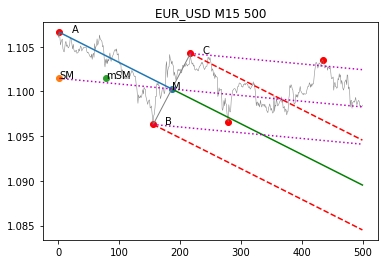

In [149]:
title=f'{inst} {tf} {count}'
df.mid_c.plot(title=title, color='gray', lw=.5);
plt.scatter(df.mid_c.idxmax(), df.mid_c.max(), c='r')
plt.scatter(df.mid_c.idxmin(), df.mid_c.min(), c='r')
if df.mid_c.idxmax() < df.mid_c.idxmin():
    df_s1 = df[df.mid_c.idxmin():]
    plt.scatter(df_s1.mid_c.idxmax(), df_s1.mid_c.max(), c='r')
    df_s2 = df[df_s1.mid_c.idxmax():]
    plt.scatter(df_s2.mid_c.idxmin(), df_s2.mid_c.min(), c='r')
    df_s3 = df[df_s2.mid_c.idxmin():]
    plt.scatter(df_s3.mid_c.idxmax(), df_s3.mid_c.max(), c='r');
else:
    df_s1 = df[df.mid_c.idxmax():]
    plt.scatter(df_s1.mid_c.idxmin(), df_s1.mid_c.min(), c='b')
    df_s2 = df[df_s1.mid_c.idxmin():]
    plt.scatter(df_s2.mid_c.idxmax(), df_s2.mid_c.max(), c='b')
    df_s3 = df[df_s2.mid_c.idxmax():]
    plt.scatter(df_s3.mid_c.idxmin(), df_s3.mid_c.min(), c='b');

# ABC pivotok
A=[df.mid_c.idxmax(), df.mid_c.max()]
B=[df_s1.mid_c.idxmin(), df_s1.mid_c.min()]
C=[df_s2.mid_c.idxmax(), df_s2.mid_c.max()]
plt.text(df.mid_c.idxmax()+20, df.mid_c.max(),'A')
plt.text(df_s1.mid_c.idxmin()+20, df_s1.mid_c.min(),'B')
plt.text(df_s2.mid_c.idxmax()+20, df_s2.mid_c.max(),'C')

# Mid points
M = [(B[0] + C[0])/2, (B[1] + C[-1])/2
plt.scatter(M[0], M[1]);
plt.text(x=M[0], y=M[1],s = 'M')
     
SM = [A[0], (B[1] + A[1])/2]
plt.scatter(SM[0], SM[1]);  
plt.text(x=SM[0], y=SM[1],s = 'SM')
     
mSM = [(B[0] + A[0])/2, (B[1] + A[1])/2]
plt.scatter(mSM[0], mSM[1]); 
plt.text(x=mSM[0], y=mSM[1],s = 'mSM')

# A --M
plt.plot([A[0], M[0]], [A[1], M[1]])
#ML
slope_ml, ic_ml = np.polyfit([A[0], M[0]], [A[1], M[1]], deg=1)
section = df.mid_c[int(M[0]):]
plt.plot(section.index, slope_ml * section.index + ic_ml, color = 'g')

# UMH
ic = C[1]- slope_ml*C[0]
section = df.mid_c[int(C[0]):]
plt.plot(section.index, slope_ml*section.index+ic, 'r--'); 
#LMH
ic = B[1]- slope_ml*B[0]
section = df.mid_c[int(B[0]):]
plt.plot(section.index, slope_ml*section.index+ic, 'r--'); 
plt.plot([B[0],C[0]], [B[1],C[1]], color= 'gray', lw=1);

# SML
slope_s, ic_s = np.polyfit([SM[0], M[0]], [SM[1], M[1]], deg=1)
section = df.mid_c[int(SM[0]):]
plt.plot(section.index,slope_s*section.index+ic_s, 'm:');
# SMUH
c = C[1]- slope_s*C[0]
section = df.mid_c[int(C[0]):]
plt.plot(section.index, slope_s*section.index+c, 'm:');
# SMLH
c = B[1]- slope_s*B[0]
section = df.mid_c[int(B[0]):]
plt.plot(section.index, slope_s*section.index+c, 'm:');